In [1]:
!pip install selenium
!pip install snscrape

In [2]:
#general packages
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

#NLTK 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

#warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#build scraper 
browser = webdriver.Chrome('/Users/dantezamora/desktop/chromedriver') 
r = browser.get('https://twitter.com/i/events/1541857402550484992') 

In [4]:
#scrape comments 


import snscrape.modules.twitter as sntwitter

query = "(from: 'canadian gp') until:2022-06-20 since:2022-06-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    
    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.content])
        
df = pd.DataFrame(tweets, columns=['Tweet'])
print(df)

df.to_csv('tweets.csv')

                                                 Tweet
0    [GP Blog]\nOfficial: Alonso picks up penalty f...
1    Verstappen Narrowly Holds Off Sainz: Takeaways...
2    Fernando Alonso’s Canadian GP Goes From Bad to...
3    Race 9. Canadian GP \nGirlfriend 2-7 Boyfriend...
4    Verstappen Narrowly Holds Off Sainz: Takeaways...
..                                                 ...
328  @maxfawcett For some reason, I thought he was ...
329  @CPHO_Canada *A concrete plan for every Canadi...
330  Nigerian Lady bags Masters from Canadian Unive...
331  Ayrton Senna still led the drivers championshi...
332  @DeniJ416 @vanishdoom84 @annclarav That a myth...

[333 rows x 1 columns]


In [5]:
df = pd.read_csv("/Users/dantezamora/Desktop/tweets.csv")

# Preprocessing 

In [6]:
df['Tweet'] = df['Tweet'].astype(str)

In [7]:
df['Tweet']

0      [GP Blog]\nOfficial: Alonso picks up penalty f...
1      Verstappen Narrowly Holds Off Sainz: Takeaways...
2      Fernando Alonso’s Canadian GP Goes From Bad to...
3      Race 9. Canadian GP \nGirlfriend 2-7 Boyfriend...
4      Verstappen Narrowly Holds Off Sainz: Takeaways...
                             ...                        
328    @maxfawcett For some reason, I thought he was ...
329    @CPHO_Canada *A concrete plan for every Canadi...
330    Nigerian Lady bags Masters from Canadian Unive...
331    Ayrton Senna still led the drivers championshi...
332    @DeniJ416 @vanishdoom84 @annclarav That a myth...
Name: Tweet, Length: 333, dtype: object

In [8]:
df.replace(r'http\S+','',regex=True,inplace=True)

In [9]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

#add additional stop words to be removed from the text
additional_list = ['amp','u',"can't",'ur','The','I','like','That','It']

for words in additional_list:
    stop_words.append(words)

def remove_stopwords(text):
    clean_text = [word for word in text if not word in stop_words]
    return clean_text   

df = df.apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dantezamora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Classify sentiment

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification 
import torch
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [11]:
def sentiment_score(df):
    tokens = tokenizer.encode(df, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))

In [12]:
df['score'] = df['Tweet'].apply(lambda x: sentiment_score(x[:512]))

In [13]:
def getclassification(label): 

  if label < 2:
    return 'Negative'
  if label == 2: 
    return 'Neutral'
  elif label > 2:
    return 'Positive'

df['sentiment'] = df['score'].apply(getclassification)

In [14]:
positive = df[df['sentiment'] == 'Positive'] 
print(str(positive.shape[0]/(df.shape[0])*100)+ "% positive sentiment")
pos = positive.shape[0]/df.shape[0]*100

neutral = df[df['sentiment'] == 'Neutral'] 
print(str(neutral.shape[0]/(df.shape[0])*100)+ "% neutral sentiment")
pos = neutral.shape[0]/df.shape[0]*100

negative = df[df['sentiment'] == 'Negative'] 
print(str(negative.shape[0]/(df.shape[0])*100)+ "% negative sentiment")
pos = negative.shape[0]/df.shape[0]*100

66.96696696696696% positive sentiment
8.108108108108109% neutral sentiment
24.924924924924923% negative sentiment


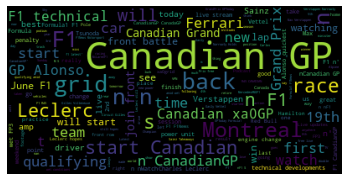

In [15]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = df['Tweet'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

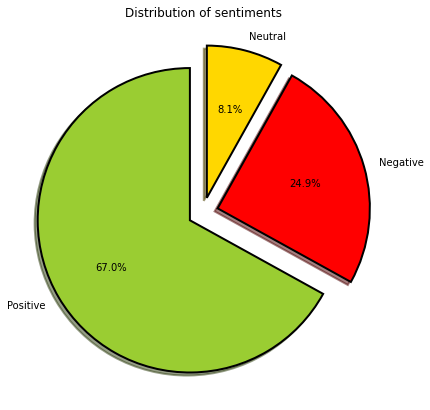

In [18]:
from matplotlib import pyplot as plt
import numpy as np
 
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen","red","gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [17]:
df

,Unnamed: 0,Tweet,score,sentiment
0,0,[GP Blog]\nOfficial: Alonso picks up penalty f...,0,Negative
1,1,Verstappen Narrowly Holds Off Sainz: Takeaways...,0,Negative
2,2,Fernando Alonso’s Canadian GP Goes From Bad to...,4,Positive
3,3,Race 9. Canadian GP \nGirlfriend 2-7 Boyfriend...,0,Negative
4,4,Verstappen Narrowly Holds Off Sainz: Takeaways...,0,Negative
...,...,...,...,...
328,328,"@maxfawcett For some reason, I thought he was ...",2,Neutral
329,329,@CPHO_Canada *A concrete plan for every Canadi...,4,Positive
330,330,Nigerian Lady bags Masters from Canadian Unive...,4,Positive
331,331,Ayrton Senna still led the drivers championshi...,4,Positive
